In [ ]:
#here we test all the components.

In [ ]:

'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()


#lets see..
a=gl.extract_core_and_interface(1,g,radius_list=[2,3,4],thickness_list=[2],vectorizer=myed.GraphLearnVectorizer())
ng=myutils.cip_to_graph(a) 
myutils.draw_many_graphs(ng)



In [ ]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get 5 grtaphs...
gr = gspan_to_eden( 'bursi.pos.gspan' )
for x in range (5):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(5):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[3],thickness_list=[1],vectorizer=myed.GraphLearnVectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_many_graphs(nice_graphs)

In [ ]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )


# we just learn a grammar from 50 graphs..  
gr = itertools.islice(gr,50)
sampler=gl.GraphLearnSampler()
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=-1)

# we look at the estimator and  draw 5 interfaces with their associated cores
#print sampler.estimator
#sampler.save('tmp/demo2.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,5)



# here we look at some stats.
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar)

In [ ]:
%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt


steps=100

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo.ge')
print "loading done"
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,9)
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=int(steps/3)+1,
                        batch_size=1,
                        n_steps=steps,
                        n_jobs=1,
                        annealing_factor=0.9)

history=[]

for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    myutils.draw_many_graphs(info['graphs'])
    
    
t = range(steps+1) 
for h in history[:3]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[3:6]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[6:]:
    plt.plot(t, h)
plt.show()




saved



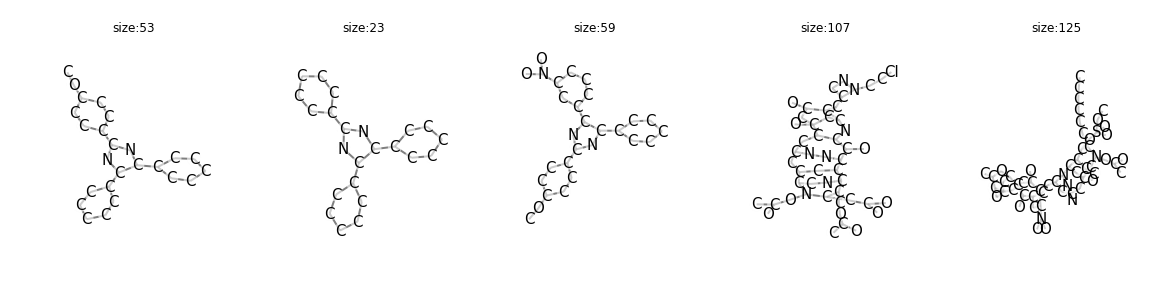

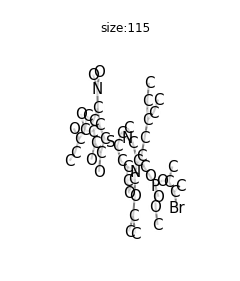

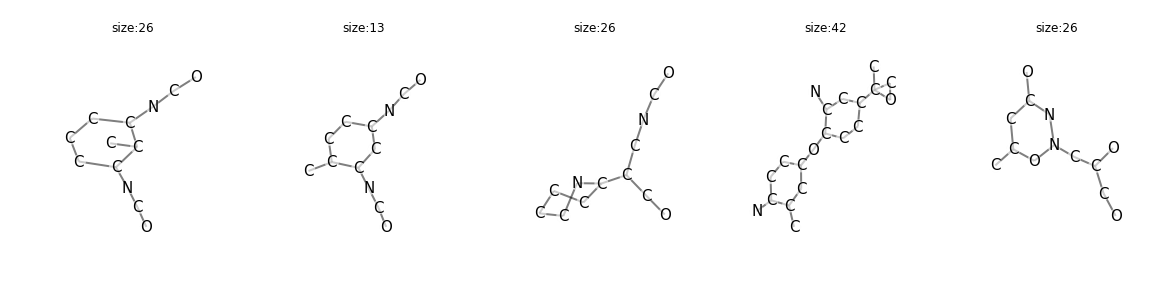

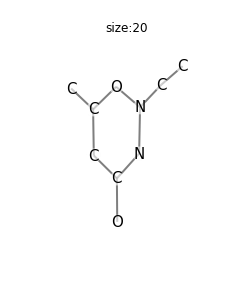

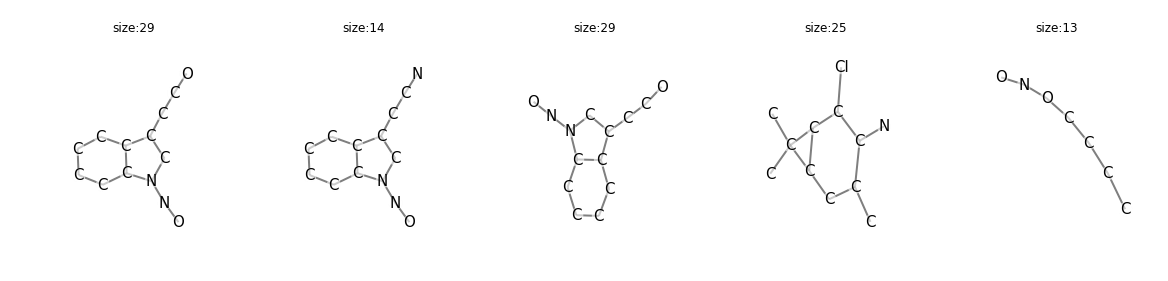

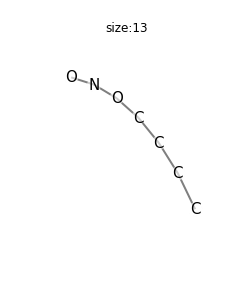

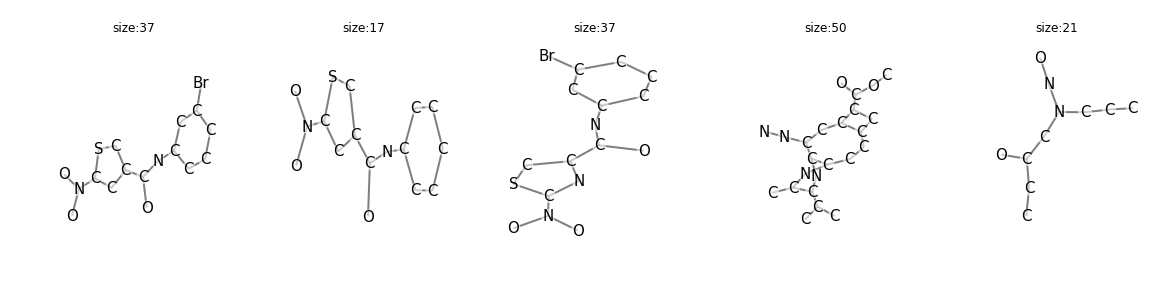

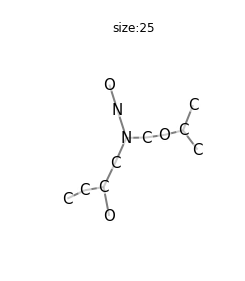

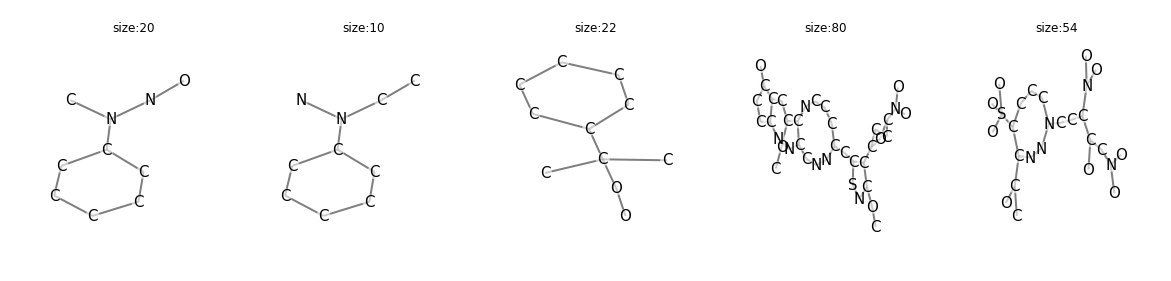

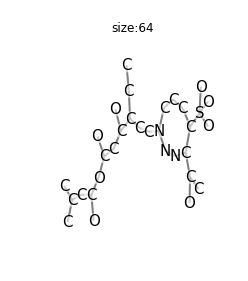

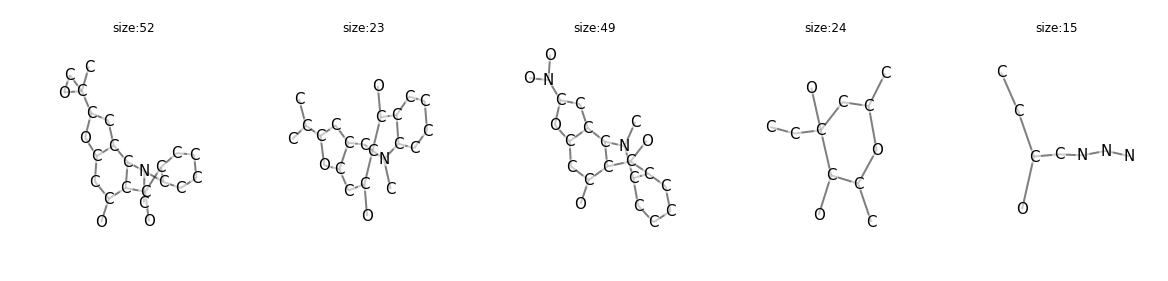

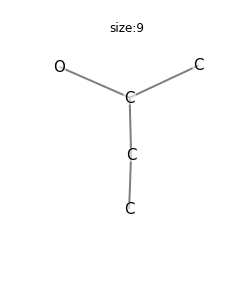

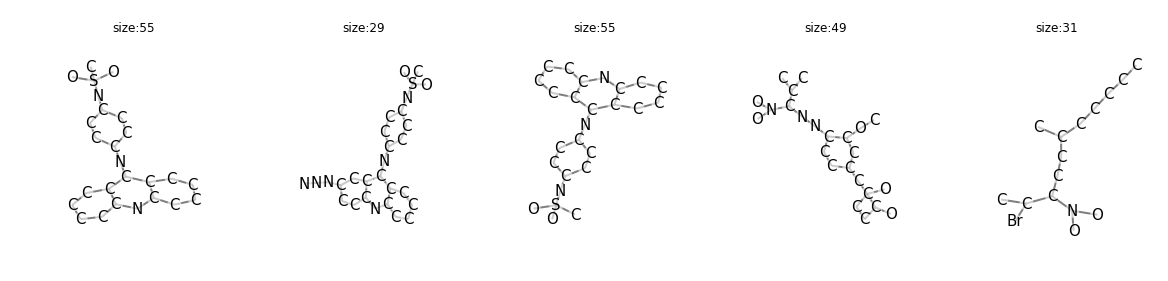

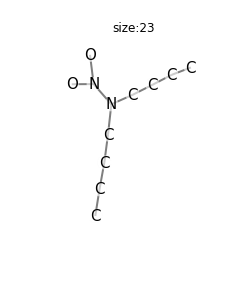

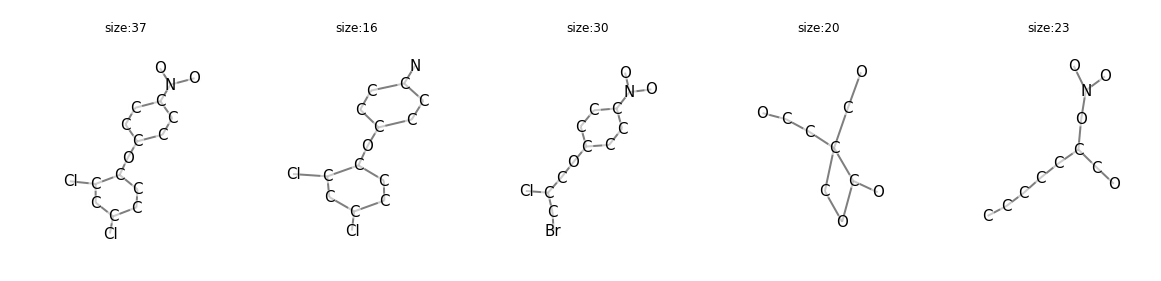

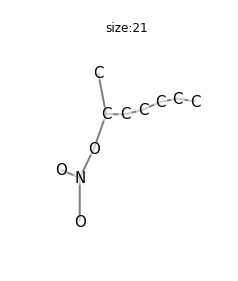

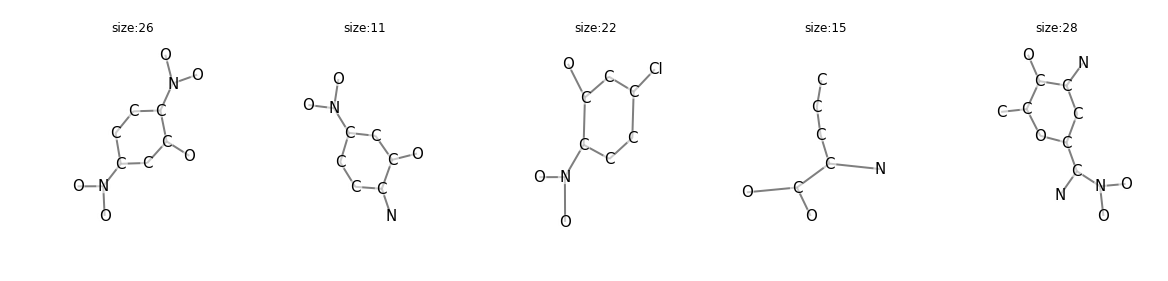

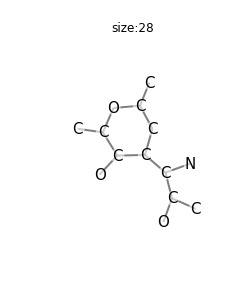

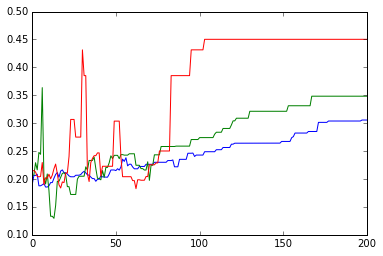

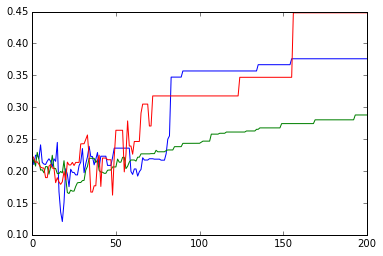

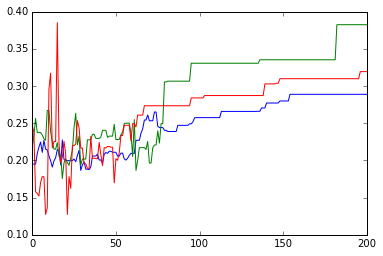

CPU times: user 8min 9s, sys: 4.29 s, total: 8min 13s
Wall time: 8min 39s


In [19]:
%%time
'''
GOOD STUFF  lets test the clusterator
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline

import graphlearn.utils.draw as myutils
import graphlearn.cluster as cl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt




steps=200

sampler=cl.cluster()

sampler.fit(gspan_to_eden( 'bursi.pos.gspan' ),  n_jobs=1)
sampler.save('tmp/cluster.ge')
print 'saved'
#sampler.load('tmp/cluster.ge')



graphs = gspan_to_eden( 'bursi.pos.gspan' )
#graphs = itertools.islice(graphs,9)
graphs = sampler.sample(graphs,
                        sampling_interval=int(steps/3)+1,
                        batch_size=1,
                        n_steps=steps,
                        n_jobs=1,
                        select_cip_max_tries = 100,
                        annealing_factor=2.0,
                        doXgraphs= 9
                        )


history=[]
for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    print info['notes']
    myutils.draw_many_graphs(info['graphs'])



t = range(steps+1) 
for h in history[:3]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[3:6]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[6:]:
    plt.plot(t, h)
plt.show()



In [17]:
print dir(history[0][0])
history.sum()

['A', 'A1', 'H', 'I', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_wrap__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__delslice__', '__dict__', '__div__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getslice__', '__gt__', '__hash__', '__hex__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__oct__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__rep

0.24947208554612943

# HERE BE DRAGONS


In [3]:
'''
inform me when done !
'''
import os
os.system("( speaker-test -t sine -f 2000 )& pid=$! ; sleep 1.0s ; kill -9 $pid")

0

In [ ]:
'''
HERE WE SEE WHY I USE SHUFFLE INSTEAD OF RANDOMCHOICE::: in the select_cips_from_grammar function...
-> pick at random as long as list of used indeces not as long as list?
-> leave it at the shuffeling?
'''
import random
%%time
x= range(1000000,0,-1)
for e in xrange(100):
    i=x.index(random.choice(x)) 
    x.remove(i)


In [ ]:
%%time
x= range(1000000,0,-1)
random.shuffle(x)
for e in xrange(100):
    i=x.pop() 


In [ ]:
from matplotlib import pyplot

a = [    pow(10,i) for i in range(10)    ]

pyplot.subplot(2,1,1)
pyplot.plot(a, color='blue', lw=2)
pyplot.yscale('log')
pyplot.show()

In [ ]:
4 / 5

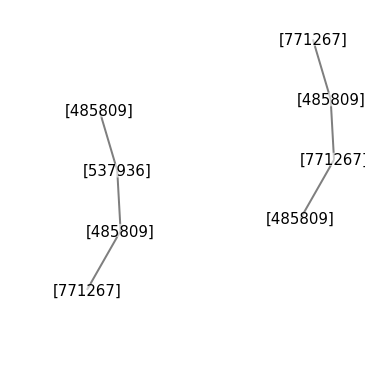

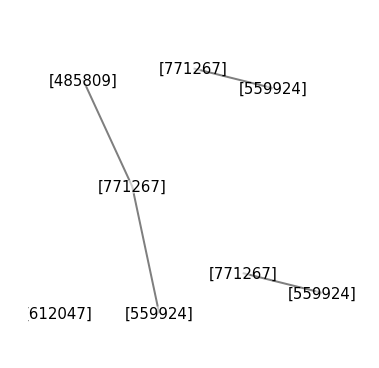

292642
292642


In [17]:
'''TESTING HASH THINGS THERE ARE COLLISIONS'''
import networkx as nx
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline

import graphlearn.utils.draw as dr

import graphlearn.utils.myeden as myed
import graphlearn.graphtools as gt

vectorizer=myed.GraphLearnVectorizer()


def get_graph(nodelabels):
    g= nx.Graph()
    for e in nodelabels:
        nodes=len(g)
        #add nodes
        g.add_nodes_from(range(nodes,nodes+len(e)))
        #add edges
        for edid in range(nodes,nodes+len(e)-1):
            g.add_edge(edid,edid+1)
        #add labels
        for i,name in enumerate(e):
            g.node[nodes+i]['label']=name
            
    vectorizer._label_preprocessing(g)
    return g
        
        
g= get_graph (['C1N1','1C1C'])
f= get_graph (['1C2','C2','C2','O'])
dr.display(g,vertex_label='hlabel')
dr.display(f,vertex_label='hlabel')

print gt.calc_interface_hash(g, 2**20-1)
print gt.calc_interface_hash(f, 2**20-1)
        
        







In [ ]:
import itertools


def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return itertools.izip_longest(fillvalue=fillvalue, *args)

s=[(1,2,3),(1,2,3),(1,2,3),(1,2,3),(1,2,3),(1,2,3),(1,2,3),(1,2,3)]
[batch for batch in grouper(s,3)]




In [ ]:
import dill
#z = dill.dumps(sampler.local_substitutable_graph_grammar)
for k,v in sampler.__dict__.iteritems():
    print k
    print len(dill.dumps(v))